# Pricing a Snowball Option Using Monte Carlo Simulation and GPU Acceleration
## Introduction
- **Purpose of the Notebook**: To demonstrate how to price a Snowball option using Monte Carlo simulation, enhanced with GPU acceleration using Numba and CUDA.
- **Overview**:
  - Snowball Options: Explanation of what they are.
  - Monte Carlo Simulation: Importance in option pricing.
  - GPU Acceleration: How Numba and CUDA can speed up computations.
- **Note**:
  - I would assume you have prior knowledge on derivatives, what are they, the common types, nomenclatures, and their importance. If you need to catch up or a refresher, the book Option, Volatility and Pricing is a good place to start. I might write a primer later for reference.

Derivative: an financial asset derived from another financial asset.
Underlying: an financial asset that underlies the derivatives. Focus on the concept of underneath.
Principal: the reference amount used in contract. It is not exchanged or transferred. The key idea there here is that this amount marks the scale of the contract, or the basis for calculating other values. An amount exists in theory on paper, or "note", hence notional.

## 1. Snowball Option as a Barrier Option
- Definition:
  - Snowball option IS a type of barrier option.
  - Snowball option IS a type of autocallables.
  - Introduction of barrier option can be dated back to xxxx.
  - Snowball means it can roll bigger. The longer you hold the higher the payoff.
  - A common conspiracy is that the word "Snowball" sounds better than "barrier", hence the rephrase marketing.
  - You having the snowball product means youve sold a put option to the security institutions.
- Key Features:
  - Knock-In Barrier: A level that, when breached, activates certain payoff conditions.
    - Lower than the initial price
  - Knock-Out Barrier: A level that, when breached, terminates the option.
    - Slightly higher than the initial price
  - Observation Dates: When the Knock-in or Knock-out event is determined. Usually in terms of frequency.
- Payoff Structure:
  - Depends on whether the asset price hits the barriers during the option's life.
- Example:
  - Lets say there exist such product:


| Contract Term                 | Example    | Description |
|-------------------------------|------------|-------------|
| Underlying                    |SPY         |             |
| Tenor                         |12-month    |             |
| Initial Observation Day       |2024-09-13  | The initial observation day is typically the start date or the next trading day|
| Initial/Reference Price       |$559.09     | The closing price of the underlying asset on the initial observation day |
| Knock-out Observation Day     |Monthly     | Fixed on a specific day each month. In this example would be 2024-10-13, 2024-11-13, etc...|
| Knock-in Observation Day      |Daily       | Every trading day from the initial observation day to the final observation day. In this example would be 2024-09-13, 2024-09-14, etc...|
| Knock-out                     |103%        | Knock-out occurs if the underlying price ≥ 103% * initial/reference price|
| Knock-in                      |70%         | Knock-in occurs if the underlying price < 70% * initial/reference price|
| Coupon                        |18%         | Annualized; specific rate depends on knock-in or knock-out events |

For the sake of nomenclature clarity,
- Regard the price, "initial" marks the beginning of a time period. "reference" stresses that another price, usually in a later date, is compared to it. They are the same in this context.
- The date setup varies from contract to contract. By setup, I mean how the calendar is calculated. Is it natural days or trading days, etc... Each institution has its own way of setting up the exact dates. You will see later that the exact date is important in pricing.

Each of the above features can vary depending on the contract. Option contracts are highly customizable, especially in the OTC market.

Simple* Payoff Structure:
1. The underlying price hits above the knock-out barrier, the option is terminated, and the investor receives the coupon base on the number of days the option was held. Let say the option was held for 1 month, then the coupon would be 1/12 * 18% = 1.5%. Payoff = 1.5% * Principal. Note that this include the scenario where it first hits the knock-in barrier, but then somehow "bounce back" to hit the knock-out barrier.
2. The underlying price goes below the knock-in barrier, and there is no knock-out event.
- If the expiry date price > initial price, Payoff = 0.
- If the expiry date price < initial price, Payoff = (expiry price - initial price) / initial price * Principal (Note on that expiry is less than the initial price, hence the payoff is negative).
3. If neither of the above events occurs, the option is held until the end of the contract term, and the investor receives the coupon. Payoff = 18% * Principal.

Insert [Visual representation of the payoff as a function of the underlying asset price.]

## 3. Monte Carlo Simulation Basics

Monte Carlo simulation is a powerful computational technique used to model and analyze complex systems that are influenced by randomness. It is particularly useful for pricing derivatives like options, where analytical solutions may not be feasible due to complex features of the instruments (I wouldn note here derivatives feature can really be complex. Do no underestimate the will of human).

Monte Carlo simulation for option pricing involves generating random price paths for the underlying asset using a stochastic process, typically Geometric Brownian Motion (GBM). The time to expiration is divided into intervals, and the asset price is updated in each interval based on drift and volatility. For each simulated path, the option payoff is calculated at expiration. The option price is then estimated by averaging the payoffs from all simulations and discounting this average back to the present using the risk-free interest rate.

I will leave the detailed explanation of Monte Carlo simulation to other resources. Here, the only useful formula is to calculate the price of the next day based on the current price.

 ## 3.1 Geometric Brownian Motion (GBM)
 
 The equation: dS_t = μ * (S_t)(dt) + σ * (S_t)(dW_t)
 
 - S_t: Asset price at time t
   - The goal of the GBM model is to describe how this term evolves as time progresses.
 - μ: drift term (expected return)
   - The deterministic component of the asset's return. It is the average rate of growth of the asset price over time, also referred to as the expected return.
   - The drift term reflects the "trend" or "direction" of the asset price movement. For instance, if μ is positive, it indicates that, on average, the asset price is expected to increase over that time period.
 - σ: volatility
   - Measures the amount of randomness or uncertainty in the asset's price movements.
   - Higher volatility implies more significant fluctuations in the asset price, while lower volatility indicates more stable price movements.
 - dW_t: Wiener process (standard Brownian motion)
   - a mathematical model used to describe random movements in continuous time.

The good way to remember this equation is to think of it as addition of two components: at any time t, the change in the asset price has deterministic and stochastic part.
- Deterministic: predictable, stead growth or decline base on drift
- Stochastic: unpredictable fluctuation due to market volatility, driven by the Wiener process.

I will leave the rest to online resources, again.

4. Environment Setup

5. Simulating Asset Price Paths
Objective: Write code to simulate the asset price paths using Monte Carlo simulation.
Steps:
Define simulation parameters (initial price, drift, volatility, time steps).
Generate random shocks using standard normal distribution.
Update asset prices iteratively.

In [25]:
import numpy as np

def simulate_asset_prices(S0, mu, sigma, T, dt, N):
    """Simulate N asset price paths over time T with time step dt."""
    time_steps = int(T / dt)
    prices = np.zeros((N, time_steps))
    prices[:, 0] = S0
    for t in range(1, time_steps):
        z = np.random.standard_normal(N)
        prices[:, t] = prices[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return prices

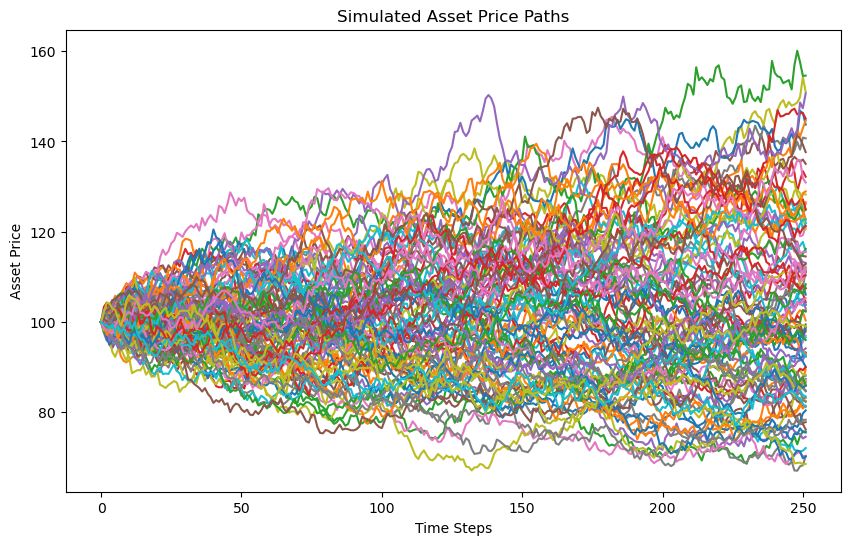

In [27]:
import matplotlib.pyplot as plt

# Parameters
S0 = 100
mu = 0.05
sigma = 0.2
T = 1.0
dt = 1/252  # Daily steps
N = 100  # Number of paths

# Simulate
prices = simulate_asset_prices(S0, mu, sigma, T, dt, N)

# Plot
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(prices[i])
plt.title('Simulated Asset Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

6. Implementing the Snowball Option Payoff
Objective: Calculate the payoff for each simulated path based on the Snowball option conditions.
Steps:
Initialize barrier flags for knock-in and knock-out.
Check barrier conditions at each time step.
Compute the final payoff based on the barriers and strike price.

In [28]:
def calculate_payoff(prices, strike, knock_in, knock_out):
    """Calculate the payoff for each price path."""
    N = prices.shape[0]
    payoffs = np.zeros(N)
    for i in range(N):
        S_path = prices[i]
        barrier_knock_in = np.any(S_path <= knock_in)
        barrier_knock_out = np.any(S_path >= knock_out)
        S_T = S_path[-1]
        if barrier_knock_out:
            payoffs[i] = 0.0
        elif barrier_knock_in:
            payoffs[i] = max(S_T - strike, 0)
        else:
            payoffs[i] = 0.0
    return payoffs

In [29]:
# Parameters
strike = 100
knock_in = 90
knock_out = 110

# Calculate payoffs
payoffs = calculate_payoff(prices, strike, knock_in, knock_out)

# Estimate option price
option_price = np.mean(payoffs) * np.exp(-mu * T)
print(f"Estimated Snowball Option Price: {option_price:.4f}")

Estimated Snowball Option Price: 0.1291


7. Enhancing Performance with Numba and CUDA
Objective: Accelerate the simulation using GPU parallelism.
Introduction to Numba and CUDA:
Numba: A JIT compiler that translates a subset of Python and NumPy code into fast machine code.
CUDA: A parallel computing platform and API model created by NVIDIA.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import math
import numba.cuda.random as curand

# GPU-Accelerated Asset Price Simulation
@cuda.jit
def simulate_asset_prices_cuda(prices, S0, mu, sigma, T, dt, M, N, seed):
    """Simulate asset price paths on the GPU."""
    idx = cuda.grid(1)
    if idx < M:
        np.random.seed(seed + idx)  # Ensure different seed for each thread
        prices[idx, 0] = S0
        drift = (mu - 0.5 * sigma**2) * dt
        sqrt_dt_sigma = sigma * math.sqrt(dt)
        for t in range(1, N + 1):
            z = curand.xoroshiro128p_normal_float64(idx, t)  # Generate random number
            prices[idx, t] = prices[idx, t-1] * math.exp(drift + sqrt_dt_sigma * z)

In [22]:
# GPU-Accelerated Payoff Calculation
@cuda.jit
def calculate_payoff_cuda(prices, payoffs, strike, knock_in, knock_out, M, N):
    """Calculate the payoff for each price path on the GPU."""
    idx = cuda.grid(1)
    if idx < M:
        barrier_knock_in = False
        barrier_knock_out = False
        S_T = prices[idx, N]
        for t in range(N + 1):
            price = prices[idx, t]
            if price <= knock_in:
                barrier_knock_in = True
            if price >= knock_out:
                barrier_knock_out = True
        if barrier_knock_out:
            payoffs[idx] = 0.0
        elif barrier_knock_in:
            payoff = S_T - strike
            payoffs[idx] = payoff if payoff > 0 else 0.0
        else:
            payoffs[idx] = 0.0

In [23]:
# Parameters
S0 = 100        # Initial asset price
mu = 0.05       # Expected return
sigma = 0.2     # Volatility
T = 1.0         # Time to maturity (in years)
dt = 1/252      # Daily steps
M = 10      # Number of simulations
N = int(T / dt) # Number of time steps

# Initialize host memory
prices_host = np.zeros((M, N + 1), dtype=np.float64)
payoffs_host = np.zeros(M, dtype=np.float64)

# Allocate device memory
prices_device = cuda.to_device(prices_host)
payoffs_device = cuda.to_device(payoffs_host)

# Configure CUDA
threads_per_block = 256
blocks_per_grid = (M + (threads_per_block - 1)) // threads_per_block

In [24]:
# Simulate Asset Prices on GPU
simulate_asset_prices_cuda[blocks_per_grid, threads_per_block](prices_device, S0, mu, sigma, T, dt, M, N, 42)

c:\Users\jacey\anaconda3\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'seed' of type Module(<module 'numpy.random' from 'c:\\Users\\jacey\\anaconda3\\lib\\site-packages\\numpy\\random\\__init__.py'>)
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_17520\403070615.py", line 13:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\jacey\AppData\Local\Temp\ipykernel_17520\403070615.py (13)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_17520\403070615.py", line 13:[0m
[1m<source missing, REPL/exec in use?>[0m


In [ ]:
# Calculate Payoffs on GPU
calculate_payoff_cuda[blocks_per_grid, threads_per_block](prices_device, payoffs_device, strike, knock_in, knock_out, M, N)

In [ ]:
# Copy results back to host
payoffs_host = payoffs_device.copy_to_host()
prices_host = prices_device.copy_to_host()

In [ ]:
# Plot a subset of simulated paths
plt.figure(figsize=(10, 6))
for i in range(10):  # Plotting first 10 paths for visualization
    plt.plot(prices_host[i], lw=0.5)
plt.title('Simulated Asset Price Paths (CUDA-Accelerated)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

# Estimate Option Price
option_price_cuda = np.mean(payoffs_host) * np.exp(-mu * T)
print(f"Estimated Snowball Option Price (CUDA-Accelerated): {option_price_cuda:.4f}")

7.1. Setting Up GPU Functions
Random Number Generation on GPU:
Use xoroshiro128p generators from Numba's CUDA random module.
Defining the CUDA Kernel:
The kernel function will run on the GPU to simulate asset paths and compute payoffs.

7.3. Launching the Kernel
Set Up Grid and Block Dimensions:

threads_per_block = 256
blocks_per_grid = (num_simulations + (threads_per_block - 1)) // threads_per_block

Create Random Number States:
rng_states = create_xoroshiro128p_states(num_simulations, seed=42)

Launch the Kernel:
monte_carlo_snowball_kernel[blocks_per_grid, threads_per_block](...)

8. Visualizing the Simulation Results <a id="section8"></a>
Objective: Provide real-time visualization of the running estimate and payoff distribution.
Tools:
Matplotlib for plotting.
plt.ion() for interactive mode.

8.1. Running Estimate Plot
Plot the estimated option price against the number of simulations completed.

8.2. Histogram of Payoffs
Plot the distribution of calculated payoffs.

8.3. Updating Plots in Real-Time
Use a loop to update the plots after each batch of simulations.
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Loop to update plots
plt.ioff()

9. Full Application Code <a id="section9"></a>
Bringing Everything Together:
Combine all functions and code segments.
Provide the full code for the application.
Ensure the code is well-commented for clarity.

9.1. Main Execution Function
Define a main() function that sets parameters and calls other functions.

9.2. Running the Simulation
Execute the main() function.
Display the final estimated option price.

10. Conclusion <a id="section10"></a>
Summary:
Successfully priced a Snowball option using Monte Carlo simulation.
Enhanced performance using GPU acceleration.
Observations:
GPU acceleration significantly reduces computation time.
Visualization aids in understanding convergence and payoff distribution.
Potential Extensions:
Incorporate more complex option features.
Use quasi-random number generators for variance reduction.
Parallelize further using multiple GPUs or distributed computing.

11. References <a id="section11"></a>
Books, articles, and online resources for further reading.
Hull, J. C. Options, Futures, and Other Derivatives.
Numba and CUDA documentation.
[Articles on Snowball options and structured products.](https://xueqiu.com/9322843818/165295388)